<center>
<h1> Allegheny County Housing Market Analysis </h1>
</center>

<center>
<h3> Annualized Rate of Return </h3>
</center>

<center>
<h5> 2022-06-20 Jonathan Hanke </h5> 
</center>
<hr> 


## 0. Python and Data Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl

In [2]:
%%time 
df1 = pd.read_csv("../DATA/1. May 2022 Property Assessments/518b583f-7cc8-4f60-94d0-174cc98310dc.csv")

<decorator-gen-61>:2: DtypeWarning: Columns (19,20,29,30,31,38,46,57,83) have mixed types.Specify dtype option on import or set low_memory=False.


CPU times: user 5.65 s, sys: 701 ms, total: 6.35 s
Wall time: 6.54 s


In [3]:
from copy import deepcopy 
df2 = deepcopy(df1)

## 1. Data Prep

### 1.1. Feature Engineering

#### Time 

In [4]:
import datetime


## Define Time-related routines:
## -----------------------------

def MM_DD_YYYY_to_datetime(MM_DD_YYYY_str, separator = '/'):
    """
    Converts a MM/DD/YYYY string to a datetime date object.
    """
    from datetime import date
    MM_str, DD_str, YYYY_str = MM_DD_YYYY_str.split(separator) 
    MM = int(MM_str)
    DD = int(DD_str)
    YYYY = int(YYYY_str)
    return datetime.date(YYYY, MM, DD)


def MM_DD_YYYY_to_datetime_with_hyphen(date_str):
    try:
        return MM_DD_YYYY_to_datetime(date_str, separator='-')
    except:
        from numpy import NaN
        return NaN

    
def timedelta_to_days(timediff):
    """
    Returns the number of days in the given timedelta object.
    """
    try:
        return timediff.days
    except:
        from numpy import NaN
        return NaN    

In [5]:
## Convert dates to datetime objects
df2['SALEDATE_date'] = df2['SALEDATE'].apply(MM_DD_YYYY_to_datetime_with_hyphen)
df2['PREVSALEDATE_date'] = df2['PREVSALEDATE'].apply(MM_DD_YYYY_to_datetime_with_hyphen)
df2['PREVSALEDATE2_date'] = df2['PREVSALEDATE2'].apply(MM_DD_YYYY_to_datetime_with_hyphen)


In [6]:
## Create owner holding times (as a datettimedelta and as number of days)
df2['OWNERHOLDINGTIME_timedelta'] = df2['SALEDATE_date'] - df2['PREVSALEDATE_date']
df2['PREVOWNERHOLDINGTIME_timedelta'] = df2['PREVSALEDATE_date'] - df2['PREVSALEDATE2_date']
df2['OWNERHOLDINGTIMEINDAYS'] = df2['OWNERHOLDINGTIME_timedelta'].apply(timedelta_to_days)
df2['PREVOWNERHOLDINGTIMEINDAYS'] = df2['PREVOWNERHOLDINGTIME_timedelta'].apply(timedelta_to_days)

##df2['OWNERHOLDINGTIMEINDAYS']

#### Price -- first level only

In [7]:
## Create the price deltas
df2['PriceDelta'] = df2['SALEPRICE'] - df2['PREVSALEPRICE']
df2['PrevPriceDelta'] = df2['PREVSALEPRICE'] - df2['PREVSALEPRICE2']

## Create the price ratios
df2['PriceRatio'] = df2['SALEPRICE'] / df2['PREVSALEPRICE']
df2['PrevPriceRatio'] = df2['PREVSALEPRICE'] / df2['PREVSALEPRICE2']

## Create the log-price difference
df2['LogPriceDiff'] = df2['PriceRatio'].apply(np.log)
df2['PrevLogPriceDiff'] = df2['PrevPriceRatio'].apply(np.log)

## Create the log-price difference rate (per day)
df2['LogPriceDiffRate'] = df2['LogPriceDiff'] / df2['OWNERHOLDINGTIMEINDAYS'];
df2['PrevLogPriceDiffRate'] = df2['PrevLogPriceDiff'] / df2['PREVOWNERHOLDINGTIMEINDAYS'];


### 1.2 Perform some data cleaning

In [337]:
## Selet only the columns we need
annualized_rate_of_return_cols = []
annualized_rate_of_return_cols += ['SALEPRICE', 'LogPriceDiffRate']
annualized_rate_of_return_cols += ['PROPERTYCITY', 'PROPERTYZIP', 'NEIGHDESC']
annualized_rate_of_return_cols += ['OWNERDESC', 'USEDESC', 'CLASSDESC']
annualized_rate_of_return_cols += ['SALEDESC']
annualized_rate_of_return_cols += ['SALEDATE', 'SALEDATE_date']
annualized_rate_of_return_cols += ['OWNERHOLDINGTIMEINDAYS']


In [338]:
## Make the dataframe we're using for the average analysis
df2_for_analysis = df2[annualized_rate_of_return_cols]
print(len(df2_for_analysis))

582137


In [339]:
## Replace infinite values with NaN
df2_for_analysis.replace([np.inf, -np.inf], np.nan, inplace=True)

## Drop NaN values
df2_for_analysis = \
    df2_for_analysis.dropna()
print(len(df2_for_analysis))



/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4166: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


308860


In [340]:
## Drop invalid "SALEDESC" rows
valid_rows = df2_for_analysis['SALEDESC'] != 'VALID SALE'
df2_for_analysis_VALID = df2_for_analysis.loc[valid_rows]
##df2_numerical_for_log_price_delta_rate_VALID.drop(invalid_rows, inplace=True)
print(len(df2_for_analysis_VALID))

## Drop the 'SALEDESC' column
#df2_for_analysis_VALID.drop(['SALEDESC'], axis=1, inplace=True)
#print(len(df2_for_analysis_VALID))


243916


In [114]:
## Compute the average annual sale price for all valid data (for all times recorded)
round(df2_for_analysis_VALID['SALEPRICE'].mean())

179390

In [115]:
## Compute the average annual percentage growth for all valid data (for all times recorded)
(np.exp(365 * df2_for_analysis_VALID['LogPriceDiffRate'].mean()) - 1) * 100

298.8920625054012

In [349]:
## Compute the average percentage growth for all valid data by year
df2_for_analysis_VALID['SALEDATE_year'] = df2_for_analysis_VALID['SALEDATE'].apply(lambda datestr: int(datestr[-4:]))

<ipython-input-349-866346f64dcd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_for_analysis_VALID['SALEDATE_year'] = df2_for_analysis_VALID['SALEDATE'].apply(lambda datestr: int(datestr[-4:]))


In [117]:
df2_for_analysis_VALID['SALEDATE_year']

1         2019
2         2021
3         2021
4         2013
6         2017
          ... 
582128    2004
582129    2009
582131    2018
582132    2007
582135    2015
Name: SALEDATE_year, Length: 243916, dtype: int64

In [139]:
## Compute the average sale price for all valid data by year
annual_sale_price_delta_series = df2_for_analysis_VALID.groupby('SALEDATE_year').mean()['SALEPRICE']
annual_sale_price_delta_series

SALEDATE_year
1950     78750.333333
1956        10.000000
1960    122684.000000
1962         1.000000
1964         1.000000
1967      3400.000000
1968     11500.000000
1970    595000.000000
1973         1.000000
1974     28750.000000
1975     17477.500000
1976      4458.833333
1977     21100.600000
1978     32815.800000
1979     17500.500000
1980     36146.333333
1981      6689.666667
1982     10590.250000
1983      3250.750000
1984     17096.125000
1985     11234.000000
1986    404701.363636
1987     47334.000000
1988    207500.400000
1989     26643.571429
1990     39700.800000
1991      9588.714286
1992         1.000000
1993     35513.461538
1994     26786.904762
1995     46178.321429
1996     41741.139535
1997     63761.378788
1998     71030.850872
1999    141567.443234
2000    154685.563897
2001    107411.350453
2002    109817.607353
2003     97863.562401
2004    112308.477660
2005    137161.791913
2006    140958.910787
2007    139217.259040
2008    145395.033533
2009    106130.201

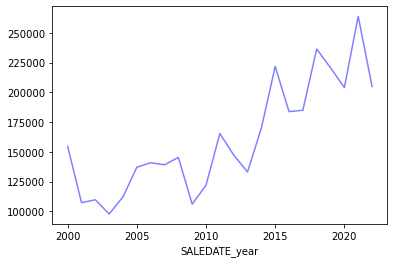

In [140]:
## Plot the annual sale price per year for all valid data
annual_sale_price_delta_series.iloc[-23:].plot(kind='line', color='b', alpha=0.5)

## CONCLUSION: General upward trend

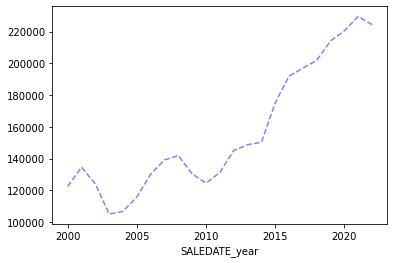

In [153]:
## View a smoothed version of this plot
smoothinng_window_size= 3
smoothed_annual_sale_price_delta_series = annual_sale_price_delta_series.rolling(smoothinng_window_size).mean()
smoothed_annual_sale_price_delta_series.iloc[-23:].plot(kind='line', color='b', linestyle='dashed', alpha=0.5)

In [192]:
## Plot the average sale price by year and its 3-year window average
annual_sale_price_by_year = pd.DataFrame([annual_sale_price_delta_series, \
                                          smoothed_annual_sale_price_delta_series])


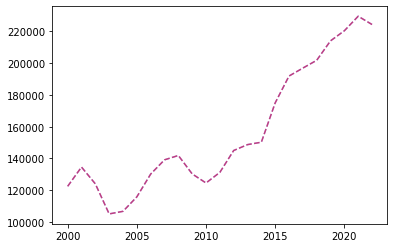

In [155]:
import matplotlib.pyplot as plt
plt.plot(smoothed_annual_sale_price_delta_series.iloc[-23:], color='b', linestyle='dashed', alpha=0.5)
plt.plot(smoothed_annual_sale_price_delta_series.iloc[-23:], color='r', linestyle='dashed', alpha=0.5)

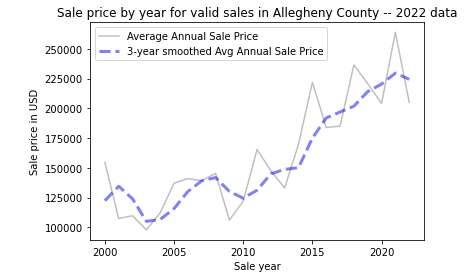

In [382]:
## Plot the annual sale price per year for all valid data
#ax = plt.axes()
p1 = annual_sale_price_delta_series.iloc[-23:].plot(kind='line', color='grey', alpha=0.5, \
                                                   label='Average Annual Sale Price')

## Plot the smmoothed annual sale price per year for all valid data
p2 = smoothed_annual_sale_price_delta_series.iloc[-23:].plot(kind='line', color='blue', linestyle='dashed', \
                                                             linewidth=3, alpha=0.5, \
                                                             label='3-year smoothed Avg Annual Sale Price',
                                                            )

plt.title("Sale price by year for valid sales in Allegheny County -- 2022 data")
plt.legend()
plt.xlabel('Sale year')
plt.ylabel('\n\nSale price in USD')
#plt.tight_layout(pad=3)

plt.savefig('Average_sale_price_for_valid_sales_2000_to_2022.png')

In [ ]:
## Let's analyze the sale price by City and Zip Code

In [206]:
df2_for_analysis_VALID.columns

Index(['SALEPRICE', 'LogPriceDiffRate', 'PROPERTYCITY', 'PROPERTYZIP',
       'NEIGHDESC', 'OWNERDESC', 'USEDESC', 'CLASSDESC', 'SALEDESC',
       'SALEDATE', 'SALEDATE_date', 'SALEDATE_year'],
      dtype='object')

In [209]:
df2_for_analysis_VALID.groupby(['PROPERTYCITY', 'PROPERTYZIP']).count()

SALEPRICE  LogPriceDiffRate  NEIGHDESC  OWNERDESC  \
PROPERTYCITY PROPERTYZIP                                                      
ALLISON PARK 15101.0           3821              3821       3821       3821   
AMBRIDGE     15003.0            212               212        212        212   
ASPINWALL    15215.0              1                 1          1          1   
BADEN        15005.0            202               202        202        202   
BAIRDFORD    15006.0             72                72         72         72   
...                             ...               ...        ...        ...   
WEST VIEW    15229.0              1                 1          1          1   
WEXFORD      15090.0           4264              4264       4264       4264   
             15237.0              2                 2          2          2   
WHITE OAK    15131.0              3                 3          3          3   
WILMERDING   15148.0            489               489        489        489   

                          USEDESC  CLASSDESC  SALEDESC  SALEDATE  \
PROPERTYCITY PROPERTYZIP                                           
ALLISON PARK 15101.0         3821       3821      3821      3821   
AMBRIDGE     15003.0          212        212       212       212   
ASPINWALL    15215.0            1          1         1         1   
BADEN        15005.0          202        202       202       202   
BAIRDFORD    15006.0           72         72        72        72   
...                           ...        ...       ...       ...   
WEST VIEW    15229.0            1          1         1         1   
WEXFORD      15090.0         4264       4264      4264      4264   
             15237.0            2          2         2         2   
WHITE OAK    15131.0            3          3         3         3   
WILMERDING   15148.0          489        489       489       489   

                          SALEDATE_date  SALEDATE_year  
PROPERTYCITY PROPERTYZIP                                
ALLISON PARK 15101.0               3821           3821  
AMBRIDGE     15003.0                212            212  
ASPINWALL    15215.0                  1              1  
BADEN        15005.0                202            202  
BAIRDFORD    15006.0                 72             72  
...                                 ...            ...  
WEST VIEW    15229.0                  1              1  
WEXFORD      15090.0               4264           4264  
             15237.0                  2              2  
WHITE OAK    15131.0                  3              3  
WILMERDING   15148.0                489            489  

[146 rows x 10 columns]

In [212]:
len(df2_for_analysis_VALID['PROPERTYCITY'].unique())

93

In [213]:
len(df2_for_analysis_VALID['PROPERTYZIP'].unique())

118

In [221]:
df2_for_analysis_VALID[['PROPERTYCITY', 'PROPERTYZIP']].drop_duplicates().groupby('PROPERTYCITY').count()

,PROPERTYZIP
PROPERTYCITY,
ALLISON PARK,1
AMBRIDGE,1
ASPINWALL,1
BADEN,1
BAIRDFORD,1
...,...
WEST NEWTON,1
WEST VIEW,1
WEXFORD,2


In [222]:
city_zipcode_count_series = df2_for_analysis_VALID[['PROPERTYCITY', 'PROPERTYZIP']].drop_duplicates().groupby('PROPERTYCITY').count()
city_zipcode_count_series

,PROPERTYZIP
PROPERTYCITY,
ALLISON PARK,1
AMBRIDGE,1
ASPINWALL,1
BADEN,1
BAIRDFORD,1
...,...
WEST NEWTON,1
WEST VIEW,1
WEXFORD,2


In [226]:
## SEE CITIES WITH >=2 ZIP CODES -- only a few, and mostly just Pittsburgh!
city_zipcode_count_series[city_zipcode_count_series['PROPERTYZIP'] >= 2]

,PROPERTYZIP
PROPERTYCITY,
BETHEL PARK,2
CLAIRTON,2
GIBSONIA,2
IMPERIAL,2
MC KEESPORT,4
MCKEESPORT,3
OAKDALE,2
PITTSBURGH,43
WEXFORD,2


In [227]:

## Analyze the average price increase per city!

In [259]:
city_list = list(df2_for_analysis_VALID['PROPERTYCITY'].unique())


## Create a dataframe of the average sale prices per city
city_avg_sale_price_by_year_df = pd.DataFrame()
for city in city_list:
    city_df = df2_for_analysis_VALID[df2_for_analysis_VALID['PROPERTYCITY'] == city]
    city_avg_sale_price_by_year_series = city_df.groupby('SALEDATE_year').mean()['SALEPRICE']
    city_avg_sale_price_by_year_df[city] = round(city_avg_sale_price_by_year_series, 0)

## Create a dataframe of the sale volumes per city
city_sale_volume_by_year_df = pd.DataFrame()
for city in city_list:
    city_df = df2_for_analysis_VALID[df2_for_analysis_VALID['PROPERTYCITY'] == city]
    city_sale_volume_by_year_series = city_df.groupby('SALEDATE_year').count()['SALEPRICE']
    city_sale_volume_by_year_df[city] = city_sale_volume_by_year_series

    
## Truncate all series to start at the year 2000
city_avg_sale_price_by_year_df = city_avg_sale_price_by_year_df.iloc[-23:] 
city_sale_volume_by_year_df = city_sale_volume_by_year_df.iloc[-23:] 


In [257]:
city_avg_sale_price_by_year_df

,PITTSBURGH,MC KEESPORT,BRADDOCK,CLAIRTON,CARNEGIE,MC KEES ROCKS,HOMESTEAD,MCKEESPORT,DUQUESNE,BRACKENRIDGE,...,VALENCIA,BAKERSTOWN,MORGAN,STURGEON,CECIL,BAIRDFORD,SAXONBURG,MOON TWP,WEST VIEW,ASPINWALL
SALEDATE_year,,,,,,,,,,,,,,,,,,,,,
2000,147101.0,33275.0,20778.0,113321.0,86767.0,88118.0,35407.0,NaN,30339.0,24506.0,...,1.0,47500.0,33964.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2001,127259.0,31818.0,24349.0,58229.0,76601.0,52109.0,34467.0,1.0,17741.0,17810.0,...,NaN,121950.0,21750.0,49000.0,NaN,38334.0,NaN,NaN,NaN,NaN
2002,123330.0,27062.0,28347.0,58628.0,50593.0,53976.0,39199.0,26334.0,22042.0,19773.0,...,35000.0,22500.0,134667.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN
2003,97658.0,42710.0,13799.0,80483.0,64652.0,90577.0,38934.0,85833.0,12151.0,17642.0,...,42000.0,135000.0,142250.0,28751.0,NaN,1.0,NaN,NaN,NaN,NaN
2004,144403.0,24500.0,25943.0,55831.0,90808.0,19131.0,178799.0,50000.0,12050.0,9701.0,...,2000.0,1.0,68334.0,20500.0,NaN,1.0,NaN,NaN,NaN,NaN
2005,128425.0,17789.0,21191.0,78548.0,44681.0,79209.0,48688.0,1.0,11110.0,17971.0,...,NaN,60000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006,150426.0,34603.0,55860.0,61376.0,57067.0,73508.0,31704.0,3500.0,8570.0,25167.0,...,NaN,1.0,50000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007,155394.0,45528.0,85668.0,84831.0,107181.0,154717.0,44956.0,30000.0,12637.0,31696.0,...,24864.0,102000.0,185900.0,85900.0,NaN,73980.0,NaN,NaN,NaN,NaN
2008,154935.0,39192.0,24709.0,70151.0,327576.0,75434.0,34460.0,NaN,17589.0,20669.0,...,109900.0,4700.0,1.0,1.0,NaN,105945.0,NaN,NaN,NaN,NaN


In [258]:
city_sale_volume_by_year_df

,PITTSBURGH,MC KEESPORT,BRADDOCK,CLAIRTON,CARNEGIE,MC KEES ROCKS,HOMESTEAD,MCKEESPORT,DUQUESNE,BRACKENRIDGE,...,VALENCIA,BAKERSTOWN,MORGAN,STURGEON,CECIL,BAIRDFORD,SAXONBURG,MOON TWP,WEST VIEW,ASPINWALL
SALEDATE_year,,,,,,,,,,,,,,,,,,,,,
2000,2803,218.0,53.0,79.0,67.0,94.0,82.0,NaN,41.0,16.0,...,3.0,2.0,5.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2001,3271,244.0,76.0,83.0,89.0,104.0,83.0,2.0,33.0,10.0,...,NaN,2.0,2.0,1.0,NaN,3.0,NaN,NaN,NaN,NaN
2002,3423,269.0,71.0,159.0,101.0,117.0,126.0,3.0,42.0,19.0,...,1.0,2.0,6.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN
2003,4116,317.0,76.0,98.0,111.0,152.0,149.0,3.0,36.0,26.0,...,1.0,3.0,4.0,4.0,NaN,1.0,NaN,NaN,NaN,NaN
2004,2123,191.0,44.0,76.0,86.0,86.0,57.0,1.0,24.0,13.0,...,1.0,1.0,3.0,2.0,NaN,1.0,NaN,NaN,NaN,NaN
2005,1991,189.0,60.0,81.0,64.0,87.0,78.0,1.0,27.0,15.0,...,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006,2091,169.0,59.0,74.0,65.0,86.0,44.0,1.0,28.0,15.0,...,NaN,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007,4397,331.0,101.0,100.0,123.0,150.0,122.0,1.0,55.0,36.0,...,11.0,1.0,5.0,4.0,NaN,5.0,NaN,NaN,NaN,NaN
2008,3738,319.0,82.0,99.0,94.0,128.0,96.0,NaN,55.0,31.0,...,1.0,2.0,2.0,4.0,NaN,3.0,NaN,NaN,NaN,NaN


In [278]:
## Determine the low-volume cities
low_volume_threshold = 20
low_volume_city_list = [city  for city in city_list  if city_sale_volume_by_year_df[city].min() < low_volume_threshold]
print(len(low_volume_city_list), "of", len(city_list), "are low-volume cities.")


## Remove the low-volume cities
trimmed_city_avg_sale_price_by_year_df = city_avg_sale_price_by_year_df.drop(low_volume_city_list, axis=1)
trimmed_city_sale_volume_by_year_df = city_sale_volume_by_year_df.drop(low_volume_city_list, axis=1)


65 of 93 are low-volume cities.


In [279]:
len(trimmed_city_avg_sale_price_by_year_df.columns)

28

In [280]:
## Create the smoothed series
trimmed_city_avg_sale_price_by_year_df

,PITTSBURGH,MC KEESPORT,BRADDOCK,CLAIRTON,CARNEGIE,MC KEES ROCKS,HOMESTEAD,DUQUESNE,TARENTUM,WEXFORD,...,OAKDALE,VERONA,MONROEVILLE,BETHEL PARK,SOUTH PARK,IMPERIAL,NATRONA HEIGHTS,ALLISON PARK,GIBSONIA,GLENSHAW
SALEDATE_year,,,,,,,,,,,,,,,,,,,,,
2000,147101.0,33275.0,20778.0,113321.0,86767.0,88118.0,35407.0,30339.0,1352082.0,230474.0,...,82614.0,93803.0,139752.0,127972.0,90554.0,95199.0,46906.0,163916.0,161450.0,107166.0
2001,127259.0,31818.0,24349.0,58229.0,76601.0,52109.0,34467.0,17741.0,31005.0,184943.0,...,95886.0,47941.0,84264.0,99729.0,75301.0,89508.0,40663.0,153383.0,148899.0,104868.0
2002,123330.0,27062.0,28347.0,58628.0,50593.0,53976.0,39199.0,22042.0,29406.0,277119.0,...,120653.0,40784.0,167734.0,92319.0,82270.0,91761.0,27195.0,120697.0,146245.0,73497.0
2003,97658.0,42710.0,13799.0,80483.0,64652.0,90577.0,38934.0,12151.0,39139.0,216481.0,...,80188.0,40688.0,317812.0,103106.0,104375.0,65901.0,55426.0,158127.0,142416.0,98068.0
2004,144403.0,24500.0,25943.0,55831.0,90808.0,19131.0,178799.0,12050.0,46103.0,112374.0,...,37681.0,25478.0,390729.0,101950.0,123108.0,23828.0,28554.0,100214.0,109535.0,49381.0
2005,128425.0,17789.0,21191.0,78548.0,44681.0,79209.0,48688.0,11110.0,848634.0,301159.0,...,62889.0,171186.0,113944.0,61831.0,603969.0,42382.0,41271.0,128345.0,48092.0,137214.0
2006,150426.0,34603.0,55860.0,61376.0,57067.0,73508.0,31704.0,8570.0,30341.0,1603685.0,...,63323.0,29293.0,78417.0,52900.0,47549.0,114385.0,128054.0,109448.0,232525.0,48916.0
2007,155394.0,45528.0,85668.0,84831.0,107181.0,154717.0,44956.0,12637.0,55969.0,274126.0,...,126621.0,56126.0,110477.0,136179.0,123430.0,99508.0,57542.0,182711.0,178331.0,123863.0
2008,154935.0,39192.0,24709.0,70151.0,327576.0,75434.0,34460.0,17589.0,36332.0,334976.0,...,119059.0,53975.0,314122.0,581887.0,83847.0,71767.0,63646.0,164991.0,174099.0,110373.0


In [291]:
## Create a smoothed version of the price increase data
smoothinng_window_size = 3
smoothed_trimmed_city_avg_sale_price_by_year_df = pd.DataFrame()
for city in trimmed_city_avg_sale_price_by_year_df.columns:
    smoothed_city_series = trimmed_city_avg_sale_price_by_year_df[city].rolling(smoothinng_window_size).mean()
    smoothed_trimmed_city_avg_sale_price_by_year_df[city] = smoothed_city_series
    

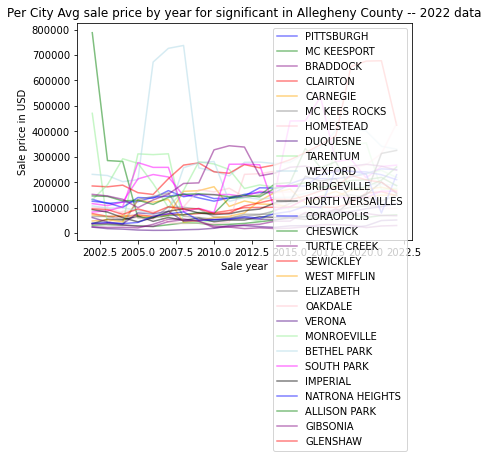

In [313]:
## View a smoothed version of this plot  


color_ind = 0
#colors = plt.cm.rainbow(np.linspace(0, 1, len(high_volume_city_list)))
colors = ['Blue', 'Green', 'Purple', 'Red', 'Orange', 'Grey', 'Pink', 'Indigo', 'Lightgreen', \
         'LightBlue', 'Magenta', 'Black'] * 5

for city in smoothed_trimmed_city_avg_sale_price_by_year_df.columns:
    smoothed_trimmed_city_avg_sale_price_by_year_df[city].plot(kind='line', \
                                                               color=colors[color_ind], \
                                                               alpha=0.5, \
                                                               label=city)
    color_ind += 1

    
plt.title("Per City Avg sale price by year for significant in Allegheny County -- 2022 data")
plt.legend()
plt.xlabel('Sale year')
plt.ylabel('Sale price in USD')


plt.savefig('smoothed_trimmed_city_average_sale_price.png')

In [294]:
high_volume_threshold = 100
high_volume_city_list = [city  for city in city_list  if city_sale_volume_by_year_df[city].min() >= high_volume_threshold]
high_volume_city_list

['PITTSBURGH', 'MC KEESPORT', 'CORAOPOLIS']

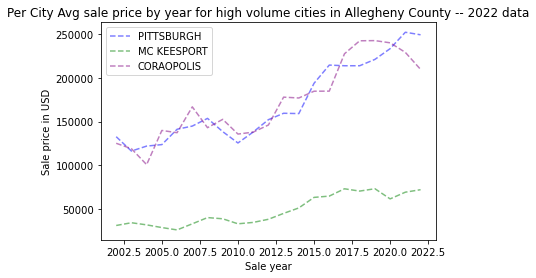

In [386]:
## View a smoothed version of this plot -- for the three high-volumne cities  
color_ind = 0
#colors = plt.cm.rainbow(np.linspace(0, 1, len(high_volume_city_list)))
colors = ['Blue', 'Green', 'Purple', 'Red', 'Orange', 'Grey', 'Pink', 'Indigo', 'Lightgreen', \
         'LightBlue', 'Magenta', 'Black'] * 5

for city in high_volume_city_list:
    smoothed_trimmed_city_avg_sale_price_by_year_df[city].plot(kind='line', \
                                                               color=colors[color_ind], \
                                                               linestyle='dashed', \
                                                               alpha=0.5, \
                                                               label=city)
    color_ind += 1

plt.title("Per City Avg sale price by year for high volume cities in Allegheny County -- 2022 data")
plt.legend()
plt.xlabel('Sale year')
plt.ylabel('\n\nSale price in USD')


plt.savefig('smoothed_Average_sale_price_for_high_volume_city_valid_sales_2000_to_2022.png')

In [322]:
high_volume_city_series_sum_by_year = city_sale_volume_by_year_df[high_volume_city_list].sum(axis=1)
high_volume_city_series_sum_by_year

SALEDATE_year
2000     3159.0
2001     3721.0
2002     3928.0
2003     4727.0
2004     2441.0
2005     2319.0
2006     2379.0
2007     4997.0
2008     4291.0
2009     3785.0
2010     4416.0
2011     5691.0
2012     7041.0
2013     6081.0
2014     7421.0
2015     8560.0
2016     8965.0
2017     9611.0
2018    11030.0
2019    12637.0
2020    11462.0
2021    14320.0
2022     4234.0
dtype: float64

In [323]:
total_volume_series_by_year = df2_for_analysis_VALID.groupby('SALEDATE_year').count()['SALEPRICE'][-23:]
total_volume_series_by_year

SALEDATE_year
2000     5102
2001     5958
2002     6446
2003     7596
2004     4051
2005     3883
2006     3912
2007     8103
2008     6829
2009     6291
2010     7074
2011     9247
2012    10964
2013     9768
2014    11890
2015    13454
2016    14411
2017    15222
2018    17720
2019    20362
2020    18606
2021    23277
2022     6840
Name: SALEPRICE, dtype: int64

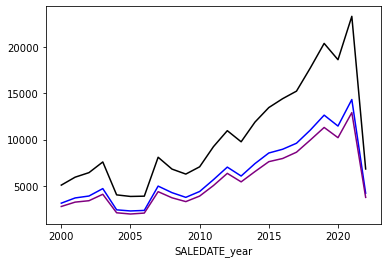

In [385]:
## Show how much of the total sale volume is in the 3 high-volume cities
high_volume_city_series_sum_by_year.plot(color='blue')
total_volume_series_by_year.plot(color='black')
city_sale_volume_by_year_df['PITTSBURGH'].plot(color='purple') 


plt.savefig('sale_volume_for_high_volume_city_valid_sales_2000_to_2022.png')

## CONCLUSION: Most of the sales volume is in these three cities -- Driven by Pittsburgh!

## Note that sales dropped off in 2022 -- incomplete data for 2022

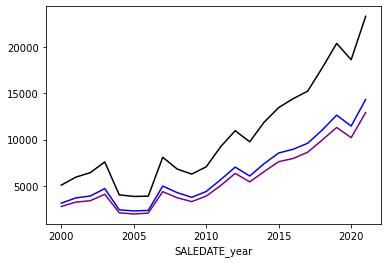

In [332]:
## Show how much of the total sale volume is in the 3 high-volume cities -- Omitting 2022 (not done!)
high_volume_city_series_sum_by_year[:-1].plot(color='blue')
total_volume_series_by_year[:-1].plot(color='black')
city_sale_volume_by_year_df['PITTSBURGH'][:-1].plot(color='purple') 

<br>
<hr>
<hr>
<hr>
<br>

## Quick turnover EDA

In [355]:
one_year_df2_VALID = df2_for_analysis_VALID[df2_for_analysis_VALID['OWNERHOLDINGTIMEINDAYS'] < 365]

one_year_flip_volume_series = one_year_df2_VALID.groupby('SALEDATE_year').count()['OWNERHOLDINGTIMEINDAYS'][-23:]
one_year_flip_volume_series

SALEDATE_year
2000     640
2001     683
2002     844
2003    1034
2004     576
2005     608
2006     527
2007    1323
2008    1374
2009    1314
2010    1349
2011    1467
2012    1380
2013    1453
2014    1717
2015    1890
2016    2063
2017    2042
2018    2164
2019    2390
2020    2040
2021    2664
2022     782
Name: OWNERHOLDINGTIMEINDAYS, dtype: int64

In [357]:
two_year_df2_VALID = df2_for_analysis_VALID[df2_for_analysis_VALID['OWNERHOLDINGTIMEINDAYS'] < (2*365)]

two_year_flip_volume_series = two_year_df2_VALID.groupby('SALEDATE_year').count()['OWNERHOLDINGTIMEINDAYS'][-23:]
two_year_flip_volume_series

SALEDATE_year
2000    1025
2001    1193
2002    1369
2003    1705
2004     931
2005     958
2006     845
2007    1961
2008    1933
2009    1791
2010    1826
2011    1996
2012    1958
2013    1957
2014    2396
2015    2707
2016    2935
2017    2980
2018    3279
2019    3592
2020    3288
2021    4193
2022    1254
Name: OWNERHOLDINGTIMEINDAYS, dtype: int64

In [360]:
three_year_df2_VALID = df2_for_analysis_VALID[df2_for_analysis_VALID['OWNERHOLDINGTIMEINDAYS'] < (3*365)]

three_year_flip_volume_series = three_year_df2_VALID.groupby('SALEDATE_year').count()['OWNERHOLDINGTIMEINDAYS'][-23:]
three_year_flip_volume_series

SALEDATE_year
2000    1365
2001    1595
2002    1831
2003    2274
2004    1236
2005    1213
2006    1165
2007    2517
2008    2308
2009    2169
2010    2237
2011    2495
2012    2521
2013    2480
2014    2973
2015    3506
2016    3704
2017    3823
2018    4325
2019    4792
2020    4431
2021    5668
2022    1645
Name: OWNERHOLDINGTIMEINDAYS, dtype: int64

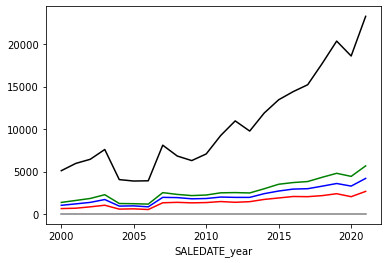

In [363]:
total_volume_series_by_year[:-1].plot(color='black')
(total_volume_series_by_year[:-1]*0.0).plot(color='grey')  ## Zero for reference
one_year_flip_volume_series[:-1].plot(color='red')
two_year_flip_volume_series[:-1].plot(color='blue')
three_year_flip_volume_series[:-1].plot(color='green')

In [364]:
## Predict where flips are most likely to be successful

In [365]:
## Predict where flips are most profitable

In [336]:
df2_for_analysis_VALID['OWNERHOLDINGTIMEINDAYS']

KeyError: 'OWNERHOLDINGTIMEINDAYS'

In [85]:
annualized_log_price_delta_series = df2_for_analysis_VALID.groupby('SALEDATE_year').mean()['LogPriceDiffRate'] * 365
annualized_log_price_delta_series


SALEDATE_year
1950      0.007939
1956      0.210392
1960      0.077679
1962      0.000000
1964      0.000000
1967     -0.226255
1968     -0.200776
1970     -0.023229
1973   -447.039546
1974      0.020456
1975      0.010540
1976     -3.264228
1977     -0.206021
1978     -0.664053
1979     -0.434152
1980    -36.247992
1981   -439.539656
1982      0.504968
1983     -0.062023
1984     -0.626384
1985     -2.053256
1986     -1.522231
1987     -0.846980
1988      0.063927
1989     -0.419443
1990     -0.471947
1991     -0.572798
1992     -1.920761
1993     -0.581805
1994     -0.787485
1995   -107.125026
1996     -4.525107
1997     -8.871749
1998      0.101047
1999     -0.109972
2000      1.294963
2001      3.363365
2002     -0.098192
2003      4.887259
2004      0.493333
2005      1.842511
2006     -1.370509
2007      2.187411
2008      2.193791
2009      2.424226
2010      3.293623
2011      1.486776
2012      1.205025
2013      1.516824
2014      2.426799
2015      1.733225
2016      0.00211

In [88]:
annualized_percent_return_rate_series = (np.exp(df2_for_analysis_VALID.groupby('SALEDATE_year').mean()['LogPriceDiffRate'] * 365) - 1) * 100
annualized_percent_return_rate_series

SALEDATE_year
1950        0.797072
1956       23.416214
1960        8.077567
1962        0.000000
1964        0.000000
1967      -20.248502
1968      -18.190419
1970       -2.296131
1973     -100.000000
1974        2.066655
1975        1.059554
1976      -96.177357
1977      -18.618429
1978      -48.523921
1979      -35.218606
1980     -100.000000
1981     -100.000000
1982       65.693207
1983       -6.013914
1984      -46.547869
1985      -87.168356
1986      -78.177557
1987      -57.129246
1988        6.601426
1989      -34.258720
1990      -37.621347
1991      -43.605450
1992      -85.350455
1993      -44.111131
1994      -54.501255
1995     -100.000000
1996      -98.916645
1997      -99.985970
1998       10.632886
1999      -10.414095
2000      265.086124
2001     2788.624092
2002       -9.352525
2003    13158.965466
2004       63.776595
2005      531.236871
2006      -74.602237
2007      791.211261
2008      796.914941
2009     1029.348468
2010     2594.029984
2011      342.281145

In [89]:
annualized_sale_counts_series = df2_for_analysis_VALID.groupby('SALEDATE_year').count()['LogPriceDiffRate']
annualized_sale_counts_series

## CONCLUSION: Look at data after 1998 -- too few data points otherwise!

SALEDATE_year
1950        6
1956        1
1960        5
1962        1
1964        1
1967        1
1968        1
1970        1
1973        1
1974        2
1975        4
1976        6
1977        5
1978       10
1979        2
1980       12
1981        9
1982       12
1983        4
1984        8
1985       15
1986       11
1987        3
1988        5
1989        7
1990       10
1991        7
1992        3
1993       13
1994       21
1995       28
1996       43
1997       66
1998     3098
1999     3488
2000     5102
2001     5958
2002     6446
2003     7596
2004     4051
2005     3883
2006     3912
2007     8103
2008     6829
2009     6291
2010     7074
2011     9247
2012    10964
2013     9768
2014    11890
2015    13454
2016    14411
2017    15222
2018    17720
2019    20362
2020    18606
2021    23277
2022     6840
Name: LogPriceDiffRate, dtype: int64

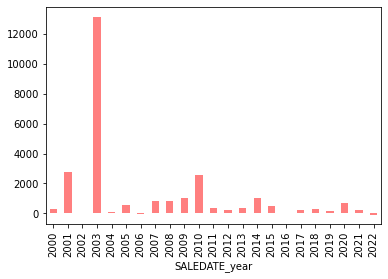

In [90]:
annualized_percent_return_rate_series.iloc[-23:].plot(kind='bar', color='r', alpha=0.5)

In [8]:
## Create groups of columns for easy reference
property_id_cols = ['PARID']
property_location_cols = ['PROPERTYHOUSENUM', \
                          'PROPERTYFRACTION', \
                          'PROPERTYADDRESS', \
                          'PROPERTYCITY', \
                          'PROPERTYSTATE', \
                          'PROPERTYUNIT', \
                          'PROPERTYZIP', \
                          'MUNICODE', \
                          'MUNIDESC',  \
                          'SCHOOLCODE', \
                          'SCHOOLDESC', \
                          'LEGAL1', \
                          'LEGAL2', \
                          'LEGAL3', \
                          'NEIGHCODE', \
                          'NEIGHDESC']
property_tax_cols = ['TAXCODE', \
                     'TAXDESC', \
                     'TAXSUBCODE', \
                     'TAXSUBCODE_DESC']
property_owner_and_municipal_cols = ['OWNERCODE', \
                                     'OWNERDESC', \
                                     'CLASS', \
                                     'CLASSDESC', \
                                     'USECODE', \
                                     'USEDESC', \
                                     'LOTAREA', \
                                     'HOMESTEADFLAG', \
                                     'CLEANGREEN', \
                                     'FARMSTEADFLAG', \
                                     'ABATEMENTFLAG', \
                                     'RECORDDATE', \
                                     'SALEDATE', \
                                     'SALEPRICE', \
                                     'SALECODE', \
                                     'SALEDESC', \
                                     'DEEDBOOK', \
                                     'DEEDPAGE', \
                                     'PREVSALEDATE', \
                                     'PREVSALEPRICE', \
                                     'PREVSALEDATE2', \
                                     'PREVSALEPRICE2', \
                                     'CHANGENOTICEADDRESS1', \
                                     'CHANGENOTICEADDRESS2', \
                                     'CHANGENOTICEADDRESS3', \
                                     'CHANGENOTICEADDRESS4', \
                                     'COUNTYBUILDING', \
                                     'COUNTYLAND', \
                                     'COUNTYTOTAL', \
                                     'COUNTYEXEMPTBLDG', \
                                     'LOCALBUILDING', \
                                     'LOCALLAND', \
                                     'LOCALTOTAL', \
                                     'FAIRMARKETBUILDING', \
                                     'FAIRMARKETLAND', \
                                     'FAIRMARKETTOTAL']
property_building_cols = ['STYLE', \
                          'STYLEDESC', \
                          'STORIES', \
                          'YEARBLT', \
                          'EXTERIORFINISH', \
                          'EXTFINISH_DESC', \
                          'ROOF', \
                          'ROOFDESC', \
                          'BASEMENT', \
                          'BASEMENTDESC', \
                          'GRADE', \
                          'GRADEDESC', \
                          'CONDITION', \
                          'CONDITIONDESC', \
                          'CDU', \
                          'CDUDESC', \
                          'TOTALROOMS', \
                          'BEDROOMS', \
                          'FULLBATHS', \
                          'HALFBATHS', \
                          'HEATINGCOOLING', \
                          'HEATINGCOOLINGDESC', \
                          'FIREPLACES', \
                          'BSMTGARAGE', \
                          'FINISHEDLIVINGAREA']
property_municipal_tracking_cols = ['CARDNUMBER', \
                                    'ALT_ID', \
                                    'TAXYEAR', \
                                    'ASOFDATE', \
                                    'MUNICIPALITY', \
                                    'NEIGHBORHOOD', \
                                    'PGH_COUNCIL_DISTRICT', \
                                    'PGH_WARD', \
                                    'PGH_PUBLIC_WORKS_DIVISION', \
                                    'PGH_POLICE_ZONE', \
                                    'PGH_FIRE_ZONE', \
                                    'TRACT', \
                                    'BLOCK_GROUP']

In [40]:
## Create a subset of the data using numerical features 
## to predict the LogPriceDiffRate
df2_numerical_for_log_price_delta_rate = \
    deepcopy(df2[numerical_columns + ['LogPriceDiffRate']])
print(len(df2_numerical_for_log_price_delta_rate))

582137


In [55]:
df2_numerical_for_log_price_delta_rate.columns

Index(['STORIES', 'YEARBLT', 'LOCALTOTAL', 'FAIRMARKETTOTAL', 'EXTERIORFINISH',
       'ROOF', 'BASEMENT', 'CONDITION', 'TOTALROOMS', 'BEDROOMS', 'FULLBATHS',
       'HALFBATHS', 'FIREPLACES', 'FINISHEDLIVINGAREA', 'LogPriceDiffRate'],
      dtype='object')

In [56]:
## Replace infinite values with NaN
df2_numerical_for_log_price_delta_rate.replace([np.inf, -np.inf], np.nan, inplace=True)

## Drop NaN values
df2_numerical_for_log_price_delta_rate = \
    df2_numerical_for_log_price_delta_rate.dropna()
print(len(df2_numerical_for_log_price_delta_rate))



234489


In [57]:
cols = df2_numerical_for_log_price_delta_rate.columns
X = df2_numerical_for_log_price_delta_rate[cols[:-1]]
y = df2_numerical_for_log_price_delta_rate[cols[-1]]

In [58]:
import sklearn
from sklearn.model_selection import train_test_split

## Make the Train-Test Split
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=496)

In [59]:
len(X_train), len(X_test)

(187591, 46898)

In [60]:
X_train[:10]

,STORIES,YEARBLT,LOCALTOTAL,FAIRMARKETTOTAL,EXTERIORFINISH,ROOF,BASEMENT,CONDITION,TOTALROOMS,BEDROOMS,FULLBATHS,HALFBATHS,FIREPLACES,FINISHEDLIVINGAREA
441318,2.0,1940.0,142700,142700,2.0,1.0,5.0,3.0,6.0,3.0,1.0,1.0,0.0,2040.0
435601,1.5,1948.0,125000,125000,3.0,1.0,5.0,4.0,6.0,3.0,1.0,1.0,1.0,1414.0
268602,2.0,1950.0,72600,72600,2.0,1.0,5.0,3.0,6.0,3.0,1.0,0.0,0.0,1344.0
495643,2.0,1928.0,74000,74000,2.0,1.0,5.0,3.0,10.0,4.0,2.0,0.0,0.0,2112.0
178090,2.0,1955.0,185200,185200,6.0,1.0,5.0,2.0,8.0,4.0,2.0,1.0,0.0,2745.0
246105,2.0,1950.0,151100,151100,2.0,1.0,5.0,3.0,7.0,3.0,1.0,1.0,0.0,1738.0
477458,2.0,1996.0,353400,353400,2.0,1.0,5.0,3.0,9.0,3.0,2.0,1.0,0.0,2294.0
9807,2.0,1940.0,30000,30000,2.0,4.0,5.0,3.0,4.0,2.0,1.0,0.0,0.0,1088.0
166762,2.0,1910.0,178700,178700,2.0,1.0,5.0,2.0,8.0,4.0,2.0,0.0,0.0,2391.0
366567,2.0,1967.0,227300,227300,2.0,1.0,5.0,3.0,8.0,4.0,2.0,1.0,1.0,2080.0


## Modelling

### 2.1 Predict the Log-price delta rate (regression - Linear)

In [61]:
## Linear Regression
from sklearn.linear_model import LinearRegression

In [62]:
## Fit the model
model_linear_regression = LinearRegression().fit(X_train, y_train)

In [64]:
#X_train.values

In [65]:
##for c in X_train.columns:
##    print(c)
##    print("  max = ", X_train[c].max())

In [66]:
#X_train['YEARBLT']

In [67]:
#y_train.max()

In [71]:
## Look at the model R^2 score -- explained variance -- VERY POOR
model_linear_regression.score(X_train, y_train)

0.00010190042696667234

### 2.2 Predict the Log-price delta rate (regression - RandomForests)


In [77]:
## Random Forests
from sklearn.ensemble import RandomForestRegressor

In [78]:
model_random_forest = RandomForestRegressor(max_depth=2, random_state=0)

In [79]:
model_random_forest.fit(X_train, y_train)

RandomForestRegressor(max_depth=2, random_state=0)

In [81]:
## Look at the model R^2 score -- explained variance - BETTER BUT STILL BAD
model_random_forest.score(X_train, y_train)

0.0079554302536603

In [95]:
## Try a new model which is deeper
model_random_forest3 = RandomForestRegressor(max_depth=3, min_samples_leaf=1, random_state=0)
model_random_forest3.fit(X_train, y_train)

## Look at the model R^2 score -- explained variance - BETTER BUT STILL BAD
model_random_forest3.score(X_train, y_train)

0.027927776164228035

In [96]:
## Try a new model which is deeper and has leaf constraints 
##   -- this indicates some overfitting since the constrained model
##   shows substantially degraded performance
model_random_forest3_10 = RandomForestRegressor(max_depth=3, min_samples_leaf=10, random_state=0)
model_random_forest3_10.fit(X_train, y_train)

## Look at the model R^2 score -- explained variance - BETTER BUT STILL BAD
model_random_forest3_10.score(X_train, y_train)

0.006494258418071275

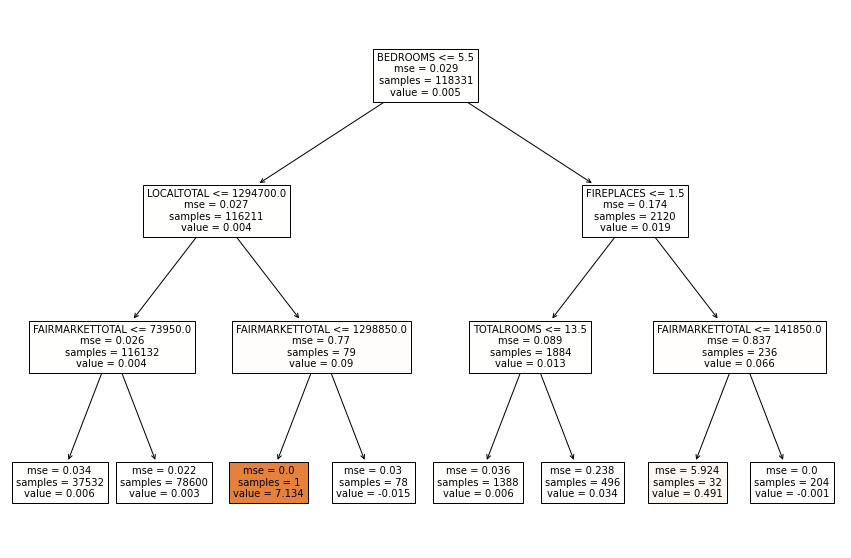

In [119]:
fn=X_train.columns
cn=X_train.columns

import matplotlib.pyplot as plt
fig, ax_list = plt.subplots(1, 1)
fig.set_size_inches(15, 10)

from sklearn import tree
tree_index_in_forest = 5
tree.plot_tree(model_random_forest3.estimators_[tree_index_in_forest],
               feature_names = fn, 
               class_names=cn,
               filled = True,
               ax=ax_list, 
               fontsize=10);

## Based on REFERENCE: https://stackoverflow.com/questions/40155128/plot-trees-for-a-random-forest-in-python-with-scikit-learn

In [112]:
ax_list[0,0]

TypeError: 'AxesSubplot' object is not subscriptable

### Repeat modelling but now only for "VALID SALE" SALEDESC.

In [155]:
## Create a subset of the data using numerical features 
## to predict the LogPriceDiffRate
df2_numerical_for_log_price_delta_rate_VALID = \
    deepcopy(df2[numerical_columns + ['SALEDESC', 'LogPriceDiffRate']])
print(len(df2_numerical_for_log_price_delta_rate_VALID))

582137


In [156]:
df2_numerical_for_log_price_delta_rate_VALID.columns

Index(['STORIES', 'YEARBLT', 'LOCALTOTAL', 'FAIRMARKETTOTAL', 'EXTERIORFINISH',
       'ROOF', 'BASEMENT', 'CONDITION', 'TOTALROOMS', 'BEDROOMS', 'FULLBATHS',
       'HALFBATHS', 'FIREPLACES', 'FINISHEDLIVINGAREA', 'SALEDESC',
       'LogPriceDiffRate'],
      dtype='object')

In [157]:
## Show the number of rows as we prune the data:
## ---------------------------------------------
print(len(df2_numerical_for_log_price_delta_rate_VALID))

## Replace infinite values with NaN
df2_numerical_for_log_price_delta_rate_VALID.replace([np.inf, -np.inf], np.nan, inplace=True)

## Drop NaN values
df2_numerical_for_log_price_delta_rate_VALID = \
    df2_numerical_for_log_price_delta_rate_VALID.dropna()
print(len(df2_numerical_for_log_price_delta_rate_VALID))

## Drop invalid "SALEDESC" rows
valid_rows = df2_numerical_for_log_price_delta_rate_VALID['SALEDESC'] != 'VALID SALE'
df2_numerical_for_log_price_delta_rate_VALID = df2_numerical_for_log_price_delta_rate_VALID.loc[valid_rows]
##df2_numerical_for_log_price_delta_rate_VALID.drop(invalid_rows, inplace=True)
print(len(df2_numerical_for_log_price_delta_rate_VALID))

## Drop the 'SALEDESC' column
df2_numerical_for_log_price_delta_rate_VALID.drop(['SALEDESC'], axis=1, inplace=True)
print(len(df2_numerical_for_log_price_delta_rate_VALID))


582137
234288
178121
178121


In [158]:
cols = df2_numerical_for_log_price_delta_rate_VALID.columns
X = df2_numerical_for_log_price_delta_rate_VALID[cols[:-1]]
y = df2_numerical_for_log_price_delta_rate_VALID[cols[-1]]

In [159]:
import sklearn
from sklearn.model_selection import train_test_split

## Make the Train-Test Split
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=496)

In [160]:
len(X_train), len(X_test)

(142496, 35625)

In [161]:
X_train[:10]

,STORIES,YEARBLT,LOCALTOTAL,FAIRMARKETTOTAL,EXTERIORFINISH,ROOF,BASEMENT,CONDITION,TOTALROOMS,BEDROOMS,FULLBATHS,HALFBATHS,FIREPLACES,FINISHEDLIVINGAREA
364236,2.0,1954.0,229000,229000,6.0,1.0,5.0,3.0,8.0,4.0,2.0,2.0,2.0,2295.0
79042,2.0,1894.0,33000,33000,1.0,4.0,5.0,4.0,8.0,4.0,2.0,0.0,0.0,1658.0
19379,2.0,1900.0,72600,72600,2.0,1.0,5.0,4.0,6.0,3.0,1.0,0.0,0.0,1224.0
528269,1.0,1973.0,182000,182000,5.0,4.0,1.0,3.0,5.0,2.0,2.0,0.0,0.0,1690.0
420908,1.5,1948.0,133800,133800,2.0,2.0,5.0,2.0,5.0,2.0,1.0,1.0,1.0,1243.0
255103,2.0,1953.0,108200,108200,2.0,1.0,5.0,3.0,7.0,3.0,1.0,0.0,1.0,1518.0
566839,2.5,1900.0,57600,57600,1.0,1.0,5.0,3.0,8.0,4.0,1.0,0.0,0.0,1961.0
184867,1.0,1972.0,199100,199100,2.0,1.0,5.0,2.0,7.0,4.0,2.0,1.0,1.0,2187.0
304277,1.0,1961.0,107300,107300,3.0,1.0,5.0,3.0,7.0,4.0,1.0,1.0,0.0,1188.0
139495,1.5,1950.0,132500,132500,2.0,1.0,5.0,3.0,4.0,2.0,1.0,2.0,1.0,1613.0


## Modelling

### 2.1 Predict the Log-price delta rate (regression - Linear)

In [162]:
## Linear Regression
from sklearn.linear_model import LinearRegression

In [163]:
## Fit the model
model_linear_regression = LinearRegression().fit(X_train, y_train)

In [164]:
#X_train.values

In [165]:
##for c in X_train.columns:
##    print(c)
##    print("  max = ", X_train[c].max())

In [166]:
#X_train['YEARBLT']

In [167]:
#y_train.max()

In [168]:
## Look at the model R^2 score -- explained variance -- VERY POOR
model_linear_regression.score(X_train, y_train)

## PREVIOUSLY: 0.00010190042696667234

0.00010520621166976163

### 2.2 Predict the Log-price delta rate (regression - RandomForests)


In [169]:
## Random Forests
from sklearn.ensemble import RandomForestRegressor

In [170]:
model_random_forest = RandomForestRegressor(max_depth=2, random_state=0)

In [171]:
model_random_forest.fit(X_train, y_train)

RandomForestRegressor(max_depth=2, random_state=0)

In [172]:
## Look at the model R^2 score -- explained variance - BETTER BUT STILL BAD
model_random_forest.score(X_train, y_train)

## PREVIOUSLY: 0.0079554302536603

0.009163627441260092

In [173]:
## Try a new model which is deeper
model_random_forest3 = RandomForestRegressor(max_depth=3, min_samples_leaf=1, random_state=0)
model_random_forest3.fit(X_train, y_train)

## Look at the model R^2 score -- explained variance - BETTER BUT STILL BAD
model_random_forest3.score(X_train, y_train)

## PREVIOUSLY: 0.0251314211790008

0.0251314211790008

In [174]:
## Try a new model which is deeper and has leaf constraints 
##   -- this indicates some overfitting since the constrained model
##   shows substantially degraded performance
model_random_forest3_10 = RandomForestRegressor(max_depth=3, min_samples_leaf=10, random_state=0)
model_random_forest3_10.fit(X_train, y_train)

## Look at the model R^2 score -- explained variance - BETTER BUT STILL BAD
model_random_forest3_10.score(X_train, y_train)

## PREVIOUSLY: 0.006494258418071275

0.006524547507156031

In [ ]:
## CONCLOUSION: Not much difference, which is surprising since the "LOVE&AFFECTION" sales were always near zero!

## EDA Question: What is the annualized rate of return for valid sales?

In [175]:
## EDA Question:  What is the average percent increase for valid sales (without NaNs) per year?

### Look for seasonal trends?

In [72]:
## Restrict the model to Pittsburgh
X_train, y_train

(        STORIES  YEARBLT  LOCALTOTAL  FAIRMARKETTOTAL  EXTERIORFINISH  ROOF  \
 441318      2.0   1940.0      142700           142700             2.0   1.0   
 435601      1.5   1948.0      125000           125000             3.0   1.0   
 268602      2.0   1950.0       72600            72600             2.0   1.0   
 495643      2.0   1928.0       74000            74000             2.0   1.0   
 178090      2.0   1955.0      185200           185200             6.0   1.0   
 ...         ...      ...         ...              ...             ...   ...   
 249237      1.5   1920.0       65900            65900             2.0   1.0   
 147705      2.0   1906.0      144500           144500             1.0   1.0   
 290996      1.0   1961.0       94600            94600             2.0   1.0   
 400197      2.0   1945.0       91900            91900             2.0   1.0   
 496972      2.0   1928.0      103900           103900             2.0   4.0   
 
         BASEMENT  CONDITION  TOTALROO

### 1.3 Create Test-Train Split

In [8]:
import sklearn

from sklearn.model_selection import train_test_split

In [33]:
## Create the features we'll use to predict 
y_df_cols = ['SALEPRICE', 'PREVSALEPRICE', 'PREVSALEPRICE2'] + \
                        ['SALEDATE', 'PREVSALEDATE', 'PREVSALEDATE2'] + \
                        ['PriceDelta', 'PrevPriceDelta'] + \
                        ['PriceRatio', 'PrevPriceRatio'] + \
                        ['LogPriceDiff', 'PrevLogPriceDiff'] + \
                        ['LogPriceDiffRate', 'PrevLogPriceDiffRate']
X_df_cols = [c  for c in df2.columns  if c not in y_small_sales_df_cols]
                         

In [34]:
X_df = df2[X_df_cols]
y_df = df2[y_df_cols]

In [36]:
## Modelling Scenario -- predict the log price increase rate
X = X_df
y = y_df['LogPriceDiffRate']

In [38]:
## Make the Train-Test Split
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=496)

In [39]:
len(X_train), len(X_test)

(465709, 116428)

In [43]:
X_train[:10]

,PARID,PROPERTYHOUSENUM,PROPERTYFRACTION,PROPERTYADDRESS,PROPERTYCITY,PROPERTYSTATE,PROPERTYUNIT,PROPERTYZIP,MUNICODE,MUNIDESC,...,PGH_FIRE_ZONE,TRACT,BLOCK_GROUP,SALEDATE_date,PREVSALEDATE_date,PREVSALEDATE2_date,OWNERHOLDINGTIME_timedelta,PREVOWNERHOLDINGTIME_timedelta,OWNERHOLDINGTIMEINDAYS,PREVOWNERHOLDINGTIMEINDAYS
187990,0133G00031000000,4119,,MAIN ST,HOMESTEAD,PA,,15120.0,840,Munhall,...,NaN,NaN,NaN,2013-04-24,2004-07-26,1996-03-13,3194 days,3057 days,3194.0,3057.0
181151,0221P00024000000,1,,LEWIS ST,PITTSBURGH,PA,,15223.0,827,Etna,...,NaN,NaN,NaN,1993-03-30,NaN,NaN,NaT,NaT,NaN,NaN
51493,0056K00065000000,41,,W ELIZABETH ST,PITTSBURGH,PA,,15207.0,115,15th Ward - PITTSBURGH,...,NaN,NaN,NaN,2020-12-15,2014-04-16,1972-10-05,2435 days,15168 days,2435.0,15168.0
196672,0302F00290000000,1112,,REBECCA ST,BRADDOCK,PA,,15104.0,843,North Braddock,...,NaN,NaN,NaN,2019-03-19,1990-11-09,NaN,10357 days,NaT,10357.0,NaN
144401,0255H00361000000,1250,,UNION ST,BRIDGEVILLE,PA,,15017.0,811,Bridgeville,...,NaN,NaN,NaN,2020-04-04,1962-05-25,NaN,21134 days,NaT,21134.0,NaN
158735,0628A00225000000,209,,S HIGHLAND AVE,CHESWICK,PA,,15024.0,815,Cheswick,...,NaN,NaN,NaN,2022-01-24,2017-01-06,1957-11-21,1844 days,21596 days,1844.0,21596.0
659,0011J00045000000,0,,FORBES AVE,PITTSBURGH,PA,,15219.0,101,1st Ward - PITTSBURGH,...,NaN,NaN,NaN,1991-12-19,NaN,NaN,NaT,NaT,NaN,NaN
231733,0132C00052000000,3406,,DOGWOOD PL,HOMESTEAD,PA,,15120.0,863,West Homestead,...,NaN,NaN,NaN,2019-02-08,1978-09-14,NaN,14757 days,NaT,14757.0,NaN
68987,0005C00275000000,0,,VIRGINIA AVE,PITTSBURGH,PA,,15211.0,119,19th Ward - PITTSBURGH,...,NaN,NaN,NaN,1912-06-08,NaN,NaN,NaT,NaT,NaN,NaN
473591,0319F00121000000,1758,,MEADOWCREST DR,PITTSBURGH,PA,,15241.0,950,Upper St. Clair,...,NaN,NaN,NaN,2017-09-29,2015-05-29,2013-06-04,854 days,724 days,854.0,724.0


## 2. Modelling

### 2.0 Prepare the numerical features we'll be using

In [52]:
type(X[:10])

pandas.core.frame.DataFrame

In [54]:
type(X_train[:10])

pandas.core.frame.DataFrame

In [59]:
[(c, type(X[c][0]))  for c in X.columns  if ]
    

[('PARID', str),
 ('PROPERTYHOUSENUM', numpy.int64),
 ('PROPERTYFRACTION', str),
 ('PROPERTYADDRESS', str),
 ('PROPERTYCITY', str),
 ('PROPERTYSTATE', str),
 ('PROPERTYUNIT', str),
 ('PROPERTYZIP', numpy.float64),
 ('MUNICODE', numpy.int64),
 ('MUNIDESC', str),
 ('SCHOOLCODE', numpy.int64),
 ('SCHOOLDESC', str),
 ('LEGAL1', str),
 ('LEGAL2', str),
 ('LEGAL3', str),
 ('NEIGHCODE', str),
 ('NEIGHDESC', str),
 ('TAXCODE', str),
 ('TAXDESC', str),
 ('TAXSUBCODE', float),
 ('TAXSUBCODE_DESC', float),
 ('OWNERCODE', numpy.int64),
 ('OWNERDESC', str),
 ('CLASS', numpy.float64),
 ('CLASSDESC', str),
 ('USECODE', numpy.int64),
 ('USEDESC', str),
 ('LOTAREA', numpy.int64),
 ('HOMESTEADFLAG', str),
 ('CLEANGREEN', float),
 ('FARMSTEADFLAG', float),
 ('ABATEMENTFLAG', float),
 ('RECORDDATE', str),
 ('SALECODE', str),
 ('SALEDESC', str),
 ('DEEDBOOK', str),
 ('DEEDPAGE', float),
 ('CHANGENOTICEADDRESS1', str),
 ('CHANGENOTICEADDRESS2', str),
 ('CHANGENOTICEADDRESS3', str),
 ('CHANGENOTICEADDRESS4',

In [61]:
[(c, type(X[c][0]))  for c in X.columns  if type(X[c][0]) != type('z')]
    

[('PROPERTYHOUSENUM', numpy.int64),
 ('PROPERTYZIP', numpy.float64),
 ('MUNICODE', numpy.int64),
 ('SCHOOLCODE', numpy.int64),
 ('TAXSUBCODE', float),
 ('TAXSUBCODE_DESC', float),
 ('OWNERCODE', numpy.int64),
 ('CLASS', numpy.float64),
 ('USECODE', numpy.int64),
 ('LOTAREA', numpy.int64),
 ('CLEANGREEN', float),
 ('FARMSTEADFLAG', float),
 ('ABATEMENTFLAG', float),
 ('DEEDPAGE', float),
 ('CHANGENOTICEADDRESS4', float),
 ('COUNTYBUILDING', numpy.int64),
 ('COUNTYLAND', numpy.int64),
 ('COUNTYTOTAL', numpy.int64),
 ('COUNTYEXEMPTBLDG', numpy.int64),
 ('LOCALBUILDING', numpy.int64),
 ('LOCALLAND', numpy.int64),
 ('LOCALTOTAL', numpy.int64),
 ('FAIRMARKETBUILDING', numpy.int64),
 ('FAIRMARKETLAND', numpy.int64),
 ('FAIRMARKETTOTAL', numpy.int64),
 ('STYLE', float),
 ('STORIES', numpy.float64),
 ('YEARBLT', numpy.float64),
 ('EXTERIORFINISH', numpy.float64),
 ('ROOF', numpy.float64),
 ('BASEMENT', numpy.float64),
 ('CONDITION', numpy.float64),
 ('TOTALROOMS', numpy.float64),
 ('BEDROOMS', 

In [68]:
## List of numerical features we can use in the prediction
numerical_columns = [
    'STORIES', \
    'YEARBLT', \
    'LOCALTOTAL', \
    'FAIRMARKETTOTAL', \
    'STORIES', \
    'YEARBLT', \
    'EXTERIORFINISH', \
    'ROOF', \
    'BASEMENT', \
    'CONDITION', \
    'TOTALROOMS', \
    'BEDROOMS', \
    'FULLBATHS', \
    'HALFBATHS', \
    'FIREPLACES', \
    'FINISHEDLIVINGAREA']

In [78]:
X_train2 = deepcopy(X_train)

X_train2 = X_train2[numerical_columns]
print(len(X_train2.columns))


16


In [79]:
print(len(X_train2))

465709


In [ ]:
## Put X and y together to clean them -- y removing NaN rows
Xy_train = X_train.append(y_train)

In [82]:
X_train2 = X_train2.dropna()
print(len(X_train2))

326467


In [ ]:
X_train2

### 2.1 Predict the Log-price delta rate

In [83]:
## Linear Regression
from sklearn.linear_model import LinearRegression

In [84]:
## Fit the model
model_linear_regression = LinearRegression().fit(X_train2, y_train)

/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').